
### A betting game

On Tuesday 21/02/2023 aired the first episode of season 24 of [Koh Lanta](https://en.wikipedia.org/wiki/Koh-Lanta), a French version of the TV show [*Survivor*](https://en.wikipedia.org/wiki/Survivor_(franchise)). 

With some friends, we play in a [Loto Lanta](https://www.loto-lanta.fr/) league, a [fantasy football](https://en.wikipedia.org/wiki/Fantasy_football_(association))-inspired game in which we vote for our champions and earn points according to their actual live performance. The points are accumulated at each episode, and the player finishing the season with the most points is the winner. 

In this first episode, the 20 participants had to take an obstacle course, where the 10 men and 10 women competed separately. My partner Ariane voted heavily for the men (6/7 votes) and earned 100 points by correctly predicting the winner of the men's event. I split my votes between men and women (3/7 votes) and found no winner, 0 points. 

### Was Ariane's strategy better?

Suppose we had 10 votes instead of 7. In this case, 
- there is the **"safe"** strategy of voting for either $100\%$ men or $100\%$ women, yielding 
  - 100 points every time (mean $100$, variance $0$).
- there is also the **"risky"** strategy of splitting votes between for $50\%$ men & $50\%$ women, yielding
  - $0$ points with a $25\%$ chance
  - $100$ points with $50\%$ chance
  - $200$ points with $25\%$ chance (mean $100$, variance $50$).

With the risky strategy, you can win more but you can also lose more.
Note that the dilemma may arise again in subsequent episodes, for example if you find yourself betting between someone strong but unpopular (potential wins in challenges but risk being eliminated at the council) and someone weak but popular. 

So is it better to play it safe or risky, or is it the same? 

### A toy model

Let's simplify the game further: in each round, let's say we have a choice between
- a "safe" action that gives $\pm 1$ point with a $50\%-50\%$ probability (mean $0$, std $1$)
- a "risky" action that is  $\pm 10$ points with a $50\%-50\%$ probability (mean $0$, std $10$).

The game is played for $H=10$ rounds, and the points are added up. 

### Maximising expected score vs. win probability

- It is clear that if the goal of the game is to maximise the average total score, we have no means of action, since whatever actions we choose, the expected total score will always be 0.
- On the other hand, if the goal is to beat an opponent, then things are different! For example, if at the last move we are behind our opponent by -6 points, the safe option never allows us to win, whereas the risky action gives a $>0$ probability of victory, so it is clearly the optimal action. 

Intuitively, I feel like I should seek risk if I am behind an opponent and play safe if I am ahead. 


**Questions:**

- Why does the strategy change between maximising the score and beating the opponent's score?
- Does the optimal possible strategy depend on the opponent's strategy, whether it is fixed, stochastic or adversarial?
- If the players play sequentially, there is clearly a minimal optimal strategy. What is it?
- If the players play simultaneously, there is potentially a Nash equilibrium. What is this equilibrium?
- In particular, on the first move, should one play risky or safe?

In [136]:
#@title Imports

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

sns.set_theme(style="white")

In [137]:
#@title Game parameters

DURATION = 15 #@param 

POINTS_SAFE = 1 #@param 
POINTS_RISKY = 10 #@param 

REWARD_LOSS = 0
REWARD_DRAW = 0.5 #@param 
REWARD_WIN = 1

SCORE_MAX = 100 #@param 
positions = np.arange(-SCORE_MAX, SCORE_MAX+1)

POLICY_TEMPERATURE = 0.01 #@param

action_size = 2

def terminal_reward_fn(p1, p2):
  return (p1 > p2) * REWARD_WIN + (p1 == p2) * REWARD_DRAW + (p1 < p2) * REWARD_LOSS

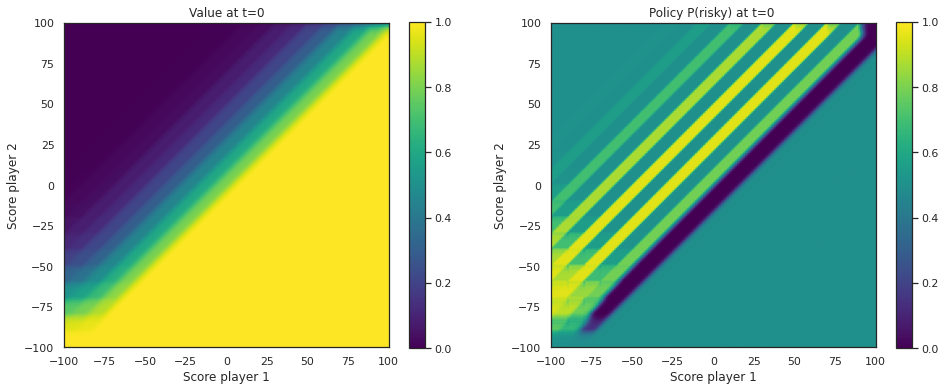

In [138]:
#@title Beating a fixed score

use_log_norm = False #@param
timestep = 0 #@param {type:"slider", min:0, max:15, step:1}

def solve_fixed_adversary_2d():
  reward = np.fromfunction(terminal_reward_fn, (positions.size, positions.size), dtype=float)
  value = np.zeros((positions.size, positions.size, DURATION+1))
  q_value = np.zeros((positions.size, positions.size, DURATION+1, action_size))
  value[:, :, -1] = reward
  for t in range(DURATION-1, -1, -1):
    for a in range(action_size):
      delta = POINTS_SAFE if a == 0 else POINTS_RISKY
      q_value[:, :, t, a] = (
          0.5 * value[np.clip(np.arange(positions.size)-delta, 0, positions.size-1), :, t+1] +
          0.5 * value[np.clip(np.arange(positions.size)+delta, 0, positions.size-1), :, t+1])
    value[:, :, t] = q_value[:, :, t,:].max(axis=-1)
  policy = softmax(q_value, temperature=POLICY_TEMPERATURE)[..., 1]
  return value, q_value, policy

def softmax(logits, temperature):
  probs = np.exp(logits/temperature)
  return probs / probs.sum(axis=-1, keepdims=True)

def plot_2d(value, policy, t):
  extent = [-SCORE_MAX, SCORE_MAX, SCORE_MAX, -SCORE_MAX]
  lin_norm = mpl.colors.Normalize(vmin=0, vmax=1)
  log_norm = mpl.colors.SymLogNorm(linthresh=np.exp(-T))
  fig, axes = plt.subplots(1, 2, figsize=(2*8, 6))

  norm = log_norm if use_log_norm else lin_norm
  im = axes.flat[0].imshow(value[..., t].T, norm=norm, extent=extent, cmap='viridis')
  axes.flat[0].set_xlabel('Score player 1')
  axes.flat[0].set_ylabel('Score player 2')
  axes.flat[0].set_title(f'Value at t={t}')
  plt.colorbar(im, ax=axes.flat[0])
  
  im = axes.flat[1].imshow(policy[..., t].T, norm=lin_norm, extent=extent, cmap='viridis')
  axes.flat[1].set_xlabel('Score player 1')
  axes.flat[1].set_ylabel('Score player 2')
  axes.flat[1].set_title(f'Policy P(risky) at t={t} ')
  plt.colorbar(im, ax=axes.flat[1])
  
  [ax.invert_yaxis() for ax in axes.flat]
  plt.show()

value2d, _, policy2d = solve_fixed_adversary_2d()
plot_2d(value2d, policy2d, t=timestep)

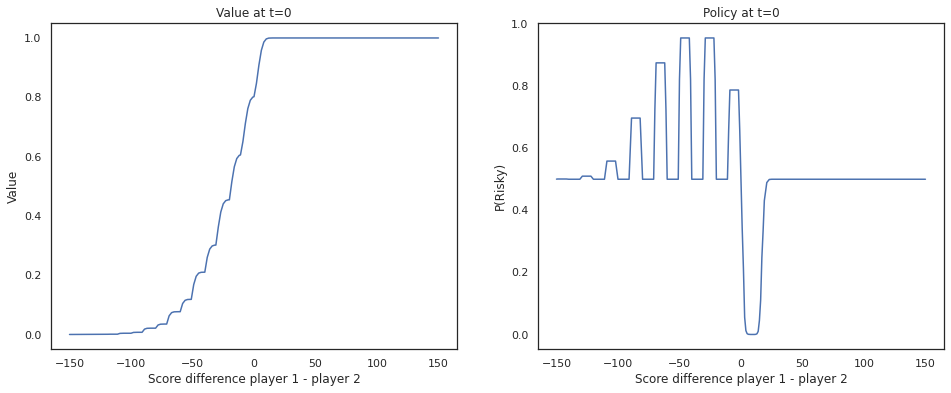

In [143]:
#@title Beating a fixed score (no score limit)

timestep = 0 #@param {type:"slider", min:0, max:15, step:1}

DELTA_SCORE_MAX = 150
positions = np.arange(-DELTA_SCORE_MAX, DELTA_SCORE_MAX+1)
terminal_reward_fn_1d = lambda delta: terminal_reward_fn(-DELTA_SCORE_MAX+delta, 0)

def solve_fixed_adversary_1d():
  reward = np.fromfunction(terminal_reward_fn_1d, (positions.size,), dtype=float)
  value = np.zeros((positions.size, DURATION+1))
  q_value = np.zeros((positions.size, DURATION+1, action_size))
  value[:, -1] = reward
  for t in range(DURATION-1, -1, -1):
    for a in range(action_size):
      delta = POINTS_SAFE if a == 0 else POINTS_RISKY
      q_value[:, t, a] = (
          0.5 * value[np.clip(np.arange(positions.size)-delta, 0, positions.size-1), t+1] +
          0.5 * value[np.clip(np.arange(positions.size)+delta, 0, positions.size-1), t+1])
    value[:, t] = q_value[:, t,:].max(axis=-1)
  policy = softmax(q_value[:, :,:], temperature=POLICY_TEMPERATURE)[:, :, 1]
  return value, q_value, policy

def plot_1d(value, policy, t):
  fig, axes = plt.subplots(1, 2, figsize=(2*8, 6))
  axes.flat[0].plot(positions, value[:, t])
  axes.flat[0].set_xlabel('Score difference player 1 - player 2')
  axes.flat[0].set_ylabel('Value')
  axes.flat[0].set_title(f'Value at t={t}')
  
  axes.flat[1].plot(positions, policy[:, t])
  axes.flat[1].set_xlabel('Score difference player 1 - player 2')
  axes.flat[1].set_ylabel('P(Risky)')
  axes.flat[1].set_title(f'Policy at t={t}')
  plt.show()

  
value1d, _, policy1d = solve_fixed_adversary_1d()
plot_1d(value1d, policy1d, t=timestep)

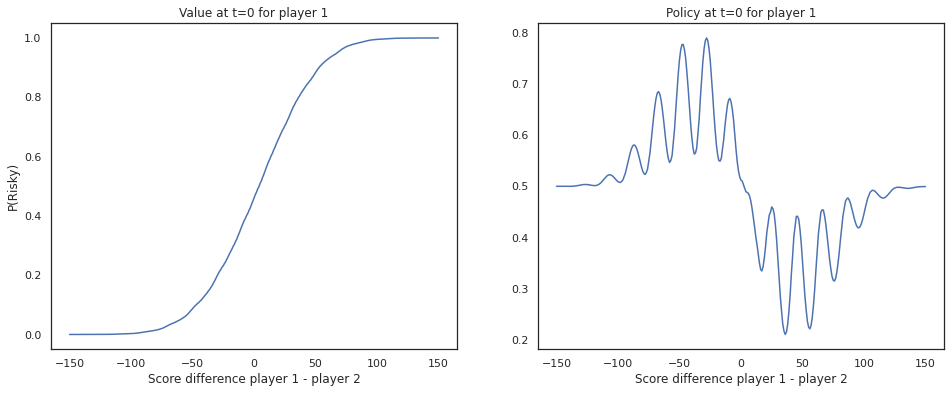

In [150]:
#@title Beating an adversary

timestep = 0 #@param {type:"slider", min:0, max:30, step:1}

def solve_minimax_adversary_1d():
  DURATION_2P = 2*DURATION
  reward = np.fromfunction(terminal_reward_fn_1d, (positions.size,), dtype=float)
  value = np.zeros((positions.size, DURATION_2P+1))
  q_value = np.zeros((positions.size, DURATION_2P+1, action_size))
  value[:, -1] = reward
  for t in range(DURATION_2P-1, -1, -1):
    for a in range(action_size):
      delta = POINTS_SAFE if a == 0 else POINTS_RISKY
      q_value[:, t, a] = (
          0.5 * value[np.clip(np.arange(positions.size)-delta, 0, positions.size-1), t+1] +
          0.5 * value[np.clip(np.arange(positions.size)+delta, 0, positions.size-1), t+1])
    q_value[:, t, :] = REWARD_WIN - (q_value[:, t, :] - REWARD_LOSS) * (REWARD_WIN - REWARD_LOSS) # Flip Q-value at every timestep
    value[:, t] = q_value[:, t,:].max(axis=-1)
  policy = softmax(q_value[:, :,:], temperature=POLICY_TEMPERATURE)[:, :, 1]
  return value, q_value, policy


def plot_minimax_1d(value, policy, t):
  fig, axes = plt.subplots(1, 2, figsize=(2*8, 6))
  axes.flat[0].plot(positions, value[:, t])
  axes.flat[0].set_xlabel('Score difference player 1 - player 2')
  axes.flat[0].set_ylabel('Value')
  axes.flat[0].set_title(f'Value at t={t//2} for player {1+t%2}')
  
  axes.flat[1].plot(positions, policy[:, t])
  axes.flat[1].set_xlabel('Score difference player 1 - player 2')
  axes.flat[0].set_ylabel('P(Risky)')
  axes.flat[1].set_title(f'Policy at t={t//2} for player {1+t%2}')
  plt.show()

value_adv, q_value_adv, policy_adv = solve_minimax_adversary_1d()
plot_minimax_1d(value_adv, policy_adv, t=timestep)